# Table of Content: <a class="anchor" id="table-of-content"></a> 
* [1. Problem Background and Motivation (Part 1)](#problem-background)
* [2. Libraries and Custom Functions (Part 1)](#import-packages)
* [3. Exploratory Data Analysis and Preparation (Part 1)](#data-prep)
* [4. Machine Learning Model (Part 2)](#ml-model)

# 1. Problem Background and Motivation </h1> <a class="anchor" id="problem-background"></a>


> # Vehicle Price Prediction Problem

>**What is the problem we are trying to solve?**<br>
>We want to better understand which feature characteristics of a vehicle are most predictive of its MSRP<br><br>
>**Why is it important?  Who cares?**<br>
>Vehicle enthusiasts can have a better idea about how they can manage their funds and invest to save enough money to be able to buy the car of their dreams within a specified timeline by being able to predict the expected price<br><br>
>**What are the possible actions that could be taken as a result of this work?**<br>
>New car buyers might use our analysis to decide which cars to buy. Sellers can adjust their offer accordingly as per the price suggested by model depending on their cars specific characteristics and earn a decent profit by staying ahead of market<br><br>
>**Who are the key stakeholders?**<br>
>rental car agencies, car sellers, new car buyers<br><br>
>**How do we define success?**<br>
>ML & Stats stories - prediction accuracy + storytelling with hypothesis testing results

* [Go to Top](#table-of-content)

# 2. Libraries & User defined Functions <a class="anchor" id="import-packages"></a>
* [Go to Top](#table-of-content)

>- Importing all the necessary modules and library functions needed for the ML model creation and data analysis

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import math

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm

> The following method provides metrics related to training dataset & testing dataset after running our definded model such as **r^2, adjusted r^2, Mean absolute error (MAE), mean absolute percentage error (MAPE) and mean squared error (MSE)**

In [2]:
def train_test_metrics(X_train,X_test,y_train,y_test,model):
    names=['R2','Adj-R2','MAE','MAPE','MSE'] 
    
    # Training Metrics
    y_hat = model.predict(X_train)
    
    # Create R2
    r2 = r2_score(y_train,y_hat).round(3)
    
    # Create adj_R2
    adj_r2 = (1-(1-r2_score(y_train,y_hat))*(len(y_train)-1)/(len(y_train)-len(model.coef_)-1)).round(3)
    
    # def mean_absolute_percentage_error(y_true, y_pred): 
      # y_true, y_pred = np.array(y_true), np.array(y_pred)
      # return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100

    
    train_metrics = [r2, adj_r2,
                     mean_absolute_error(y_train,y_hat).round(3),
                     mean_absolute_percentage_error(y_train,y_hat).round(3)*100,
                     (mean_squared_error(y_train,y_hat)*len(y_train)).round(3)
                    ]
    train_metrics = pd.DataFrame({'Train':train_metrics},index=names)
    
    # Testing Metrics
    y_hat = model.predict(X_test)
    test_metrics = [r2_score(y_test,y_hat).round(3),
                    (1-(1-r2_score(y_test,y_hat))*(len(y_test)-1)/(len(y_test)-len(model.coef_)-1)).round(3),
                    mean_absolute_error(y_test,y_hat).round(3),
                    mean_absolute_percentage_error(y_test,y_hat).round(3)*100,
                    (mean_squared_error(y_test,y_hat)*len(y_test)).round(3)
                   ]
    test_metrics = pd.DataFrame({'Test':test_metrics},index=names)
    
    all_metrics = train_metrics.merge(test_metrics,left_index=True,right_index=True)
    print(all_metrics)

# 3. Exploratory Data Analysis & Preparation <a class="anchor" id="data-prep"></a>
* [Go to Top of Notebook](#table-of-content)

> Basic Outline of Work

- [X] [Basic understanding of data](#initial-evaluation)
- [X] [Initial Cleanup - duplicates, missing values](#missing-values)
- [X] [Outlier Detection & Treatment](#outliers)
- [X] [Feature Selection](#feature-selection)
- [X] [Feature Transformations](#feature-transformations)
- [X] [Data Partitioning](#data-split)

**3.1. Having basic understanding of initial dataset**
>- Reading the data and trying to make sense of the data.

In [3]:
df = pd.read_csv('car_pricing_data.csv')
df.columns = df.columns.str.replace(' ', '')
df.tail()

,Make,Model,Year,EngineFuelType,EngineHP,EngineCylinders,TransmissionType,Driven_Wheels,NumberofDoors,MarketCategory,VehicleSize,VehicleStyle,highwayMPG,citympg,Popularity,MSRP
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,46120
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,56670
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50620
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50920
11913,Lincoln,Zephyr,2006,regular unleaded,221.0,6.0,AUTOMATIC,front wheel drive,4.0,Luxury,Midsize,Sedan,26,17,61,28995


>**Observations:**<br>
>>**11913 Records**<br><br>
>>**Target:** The most obvious candidate is **MSRP**<br>
>>- Other possibiities for prediction: some metric reflecting "popularity".  Why are some properties more popular & desirable and others are not? In this dataset we only have one feature on popularity - we have no information on how it got determined.
<br><br>


| Feature          	| Thoughts/Expectations                     	|
|------------------	|-------------------------------------------	|
| Make:    	        | proxy for brand and hence MSRP (+)            |
| Model:      	    | perhaps (+) on price                       	|
| Year: 	        | Will definitely impact price (+) 	            |
| Engine fuel type: | another feature I think will impact  	        |
| Engine HP: 	    | maybe (+) on price                        	|
| Engine cylinders: | would think (+) on price                  	|
| Transmission type:| (+) for Automatic, (-) for Manual          	|
| Driven wheels:    | will impact price, all wheel > front wheel    |
| Number of doors:  | will impact price (+)                       	|
| Market category:  | will matter if it fits multiple category   	|
| Vehicle size:     | will matter          	                        |
| Vehicle style:    | Will matter , SUV > Hatchback           	    |
| Highway MPG:    	| More MPG , more MSRP (+)                      |
| City MPG:         | More City MPG, more MSRP (+)          	    |
| Popularity:       | should be +++                             	|


>* Now we try to figure out what is the datatype of each feature that we have taken into consideration

In [4]:
df.dtypes

Make                 object
Model                object
Year                  int64
EngineFuelType       object
EngineHP            float64
EngineCylinders     float64
TransmissionType     object
Driven_Wheels        object
NumberofDoors       float64
MarketCategory       object
VehicleSize          object
VehicleStyle         object
highwayMPG            int64
citympg               int64
Popularity            int64
MSRP                  int64
dtype: object

**3.2. Finding out missing values for each variable and its treatment**
>* After this, we need to see what is number of null records pertaining to each column in the dataset. This will give us an idea about which column we can drop straightaway, dealing with which otherwise will lead to putting unnecessary efforts with diminishing return in terms of effort.

In [5]:
df.isnull().sum()

Make                   0
Model                  0
Year                   0
EngineFuelType         3
EngineHP              69
EngineCylinders       30
TransmissionType       0
Driven_Wheels          0
NumberofDoors          6
MarketCategory      3742
VehicleSize            0
VehicleStyle           0
highwayMPG             0
citympg                0
Popularity             0
MSRP                   0
dtype: int64

>* Doing this will give us an idea of what are the null records pertaining to each column.

In [6]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Make,11914,48,Chevrolet,1123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Model,11914,915,Silverado 1500,156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,11914,NaN,NaN,NaN,2010.38,7.57974,1990,2007,2015,2016,2017
EngineFuelType,11911,10,regular unleaded,7172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EngineHP,11845,NaN,NaN,NaN,249.386,109.192,55,170,227,300,1001
EngineCylinders,11884,NaN,NaN,NaN,5.62883,1.78056,0,4,6,6,16
TransmissionType,11914,5,AUTOMATIC,8266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Driven_Wheels,11914,4,front wheel drive,4787,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NumberofDoors,11908,NaN,NaN,NaN,3.43609,0.881315,2,2,4,4,4
MarketCategory,8172,71,Crossover,1110,NaN,NaN,NaN,NaN,NaN,NaN,NaN


>**Note:**<br>
>- We have a lot of categorical variables to look at and transform to numerical features at some point
>> For now, first I'm actually going to drop the **Market Category** entirely because it's quite difficult to make sense of without a lot of research.  Also it has a lot of missing values whose cleanup is hard to do without additional research and knowledge.

>- Then, for Engine HP and Engine cylinder, I am simply going to remove rows with missing values as no of such records is very less compared to total number of records.


In [7]:
# Dropping Market Category variable after much thought
df = df.drop('MarketCategory', axis=1)
print('Number of original records:', len(df))

Number of original records: 11914


In [8]:
# drop all rows that contain missing values
df = df.dropna()
print('Number of records after dropping missing values:', len(df))

Number of records after dropping missing values: 11812


**3.3. Duplicate records identification and treatment**
>- Now we attempt to find if there are any duplicate values and if so, remove those duplicate values

In [9]:
#Finding out how many duplicate rows exist
duplicate = df[df.duplicated()]
 
print("No of duplicate Rows :",len(duplicate))

No of duplicate Rows : 720


In [10]:
# Removing duplicate rows from the dataframe
df.drop_duplicates(inplace=True)
print('Number of records after dropping missing values:', len(df))

Number of records after dropping missing values: 11092


>* Now let's take a look at the central tendencies, distribution and ranges of the numerical variables

In [11]:
numerical_variables = ['MSRP','Year', 'EngineHP', 'EngineCylinders', 'NumberofDoors', 'highwayMPG', 'citympg','Popularity']

In [12]:
def my_summary_stats(X,feature_list):
    temp = pd.DataFrame(dict(mean = X[feature_list].mean().round(2),
                             median = X[feature_list].median().round(2),
                             std_dev = X[feature_list].std().round(2),
                             min_val = X[feature_list].min().round(2),
                             max_val = X[feature_list].max().round(2),
                             missing_vals = X[feature_list].isnull().sum(),
                             outlier_issue = np.where(X[feature_list].std()/X[feature_list].mean() > 2,
                                                      True,False)
                            ))
    return temp

**3.4. Outlier Detection, Identification & Treatment**
>- Now we run a custom function to determine if we have any outliers amongst our numerical variables, along with getting insights on central tendencies and range of our dataset

In [13]:
my_summary_stats(df,numerical_variables)

,mean,median,std_dev,min_val,max_val,missing_vals,outlier_issue
MSRP,41908.53,30597.5,61743.05,2000.0,2065902.0,0,False
Year,2010.69,2015.0,7.24,1990.0,2017.0,0,False
EngineHP,253.53,240.0,110.18,55.0,1001.0,0,False
EngineCylinders,5.69,6.0,1.77,0.0,16.0,0,False
NumberofDoors,3.45,4.0,0.87,2.0,4.0,0,False
highwayMPG,26.27,25.0,7.48,12.0,354.0,0,False
citympg,19.30,18.0,6.61,7.0,137.0,0,False
Popularity,1556.68,1385.0,1443.59,2.0,5657.0,0,False


>- Thus after running the dataframe from our custom function, we realize that we dont have to deal with any outliers while considering only numerical variables

>- However in my case, I would like to deal with only those cars whose MSRP >=6k USD & MSRP <= 100k USD, about generally affordable cars accepted by maximum of upper middle class families.

In [14]:
# Remove outliers based on thresholds described above
print('Number of records BEFORE outlier handling:', len(df))
df = df[(df['MSRP'] > 6000) & (df['MSRP'] < 100000)]
print('Number of records AFTER outlier handling:', len(df))

Number of records BEFORE outlier handling: 11092
Number of records AFTER outlier handling: 9129


>- Time to familiarize ourselves with data using visualizations

In [15]:
#sns.catplot(x="EngineCylinder", y="MSRP", data=df, height=7,aspect=1.5)

<AxesSubplot:xlabel='MSRP', ylabel='Count'>

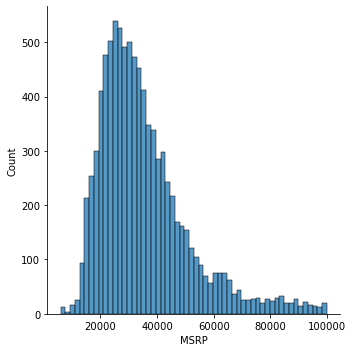

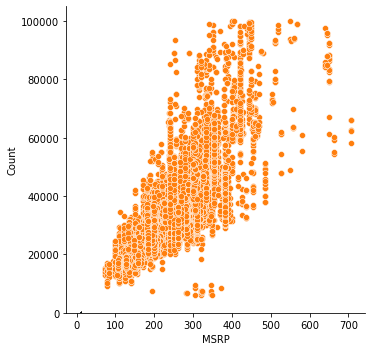

In [16]:
sns.displot(df['MSRP'])
sns.displot(np.log1p(df['MSRP']))
sns.scatterplot(x='EngineHP',y='MSRP',data=df)

>**Note:**<br>
We removed outliers for **MSRP** 
Looking at the distribution of our target variable (price), we see there's a bit of a problem with a skewness
Since this is our target variable and we plan to use regression techniques, we should transform this variable
So that it does not violate OLS regression assumptions - to make it more normal - we will apply a log transformation
In our data transformations section below

**3.5. Feature Selection** <br>
<br>
**First, deal with numerical variables**
>- Now there are two things that we need to do so that it enables us to better select best features that will be a part of our model and help predict target variable in a logical way.
>>- Evaluate correlation coefficients of numerical variables <br/>
>>- Evaluate categorical variables vs target variables

> We show the correlation of multiple numerical variables with MSRP using a simple barplot

<AxesSubplot:xlabel='MSRP'>

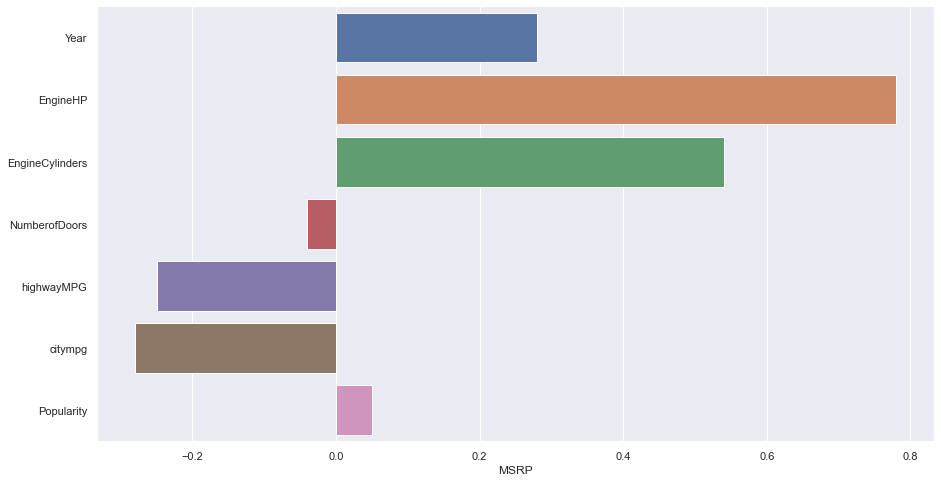

In [17]:
c = df[numerical_variables].corr()[['MSRP']].round(2)
sns.set(rc= {'figure.figsize':(15,8)})
sns.barplot(x=c.MSRP[1:],y=c.index[1:],data=c, orient='h')


>**Note:**<br>
>Our short list of features most correlated with price:
>1. Engine HP (+)
>2. Engine Cylinders (+)
>3. highway MPG (-)
>4. city mpg (-)
>5. Year (+)
<br>
<br>

>- We also need to check if any of these features are highly correlated with each other

In [18]:
df[['EngineHP','EngineCylinders','highwayMPG',
    'citympg','Year']].corr().round(2)

,EngineHP,EngineCylinders,highwayMPG,citympg,Year
EngineHP,1.00,0.77,-0.45,-0.50,0.23
EngineCylinders,0.77,1.00,-0.63,-0.64,-0.13
highwayMPG,-0.45,-0.63,1.00,0.82,0.28
citympg,-0.50,-0.64,0.82,1.00,0.24
Year,0.23,-0.13,0.28,0.24,1.00


>- Thus observing this table we need to keep only one of (Engine HP, Engine Cylinders), I will go with HP as it is a ubiquitous term amongst general customers
>- I have decided to retain all negative price correlates

>Final Set of Numerical Variables:<br>
>- Engine HP<br>
>- city mpg<br>
>- Year<br>
>- highway MPG<br>

In [19]:
# Dropping all numerical vars not in the final list above
df = df.drop(['EngineCylinders', 'NumberofDoors', 
              'Popularity'], axis=1)

**Then, take care of categorical variables**
>- Now we start taking into consideration the categorical variables, clean up these variables and think about how we can include these variables in our modelling

In [20]:
# Create temporary dataframe with target and categorical variables only
categorical = ['object']
temp_df = pd.merge(df['MSRP'],df.select_dtypes(include=categorical),left_index=True,right_index=True)

In [21]:
# Compute average target values for all categorical alternatives
def target_by_cats(temp_df):
    '''
    This function operates under the idea that the input dataframe (temp_df) has a numerically defined target
    variable in the first column and that all remaining features are categorical
    '''
    global_mean = temp_df.iloc[:,0].mean()
    target = temp_df.columns[0]
    for col in temp_df.columns[1:]:
        df_group = temp_df.groupby(by=col)[target].agg(['mean']).round(2)
        df_group['diff'] = (df_group['mean'] - global_mean).round(2)
        display(df_group)
        
target_by_cats(temp_df)

,mean,diff
Make,,
Acura,39936.16,4511.75
Alfa Romeo,61600.00,26175.59
Aston Martin,98200.00,62775.59
Audi,49984.90,14560.49
BMW,56952.48,21528.07
Buick,32937.11,-2487.30
Cadillac,58268.17,22843.76
Chevrolet,32391.35,-3033.06
Chrysler,31069.12,-4355.29


,mean,diff
Model,,
1 Series,38276.67,2852.26
1 Series M,46135.00,10710.59
124 Spider,26895.00,-8529.41
2,15821.67,-19602.74
2 Series,41697.06,6272.65
...,...,...
iQ,16168.75,-19255.66
tC,21546.43,-13877.98
xA,12996.67,-22427.74


,mean,diff
EngineFuelType,,
diesel,42840.32,7415.91
electric,34511.92,-912.49
flex-fuel (premium unleaded recommended/E85),48641.92,13217.51
flex-fuel (premium unleaded required/E85),81466.00,46041.59
flex-fuel (unleaded/E85),37093.04,1668.63
natural gas,28065.00,-7359.41
premium unleaded (recommended),41033.76,5609.35
premium unleaded (required),52033.14,16608.73
regular unleaded,29080.35,-6344.06


,mean,diff
TransmissionType,,
AUTOMATED_MANUAL,40012.95,4588.54
AUTOMATIC,36698.16,1273.75
DIRECT_DRIVE,33620.00,-1804.41
MANUAL,29206.51,-6217.90
UNKNOWN,8096.67,-27327.74


,mean,diff
Driven_Wheels,,
all wheel drive,42044.44,6620.03
four wheel drive,40270.61,4846.20
front wheel drive,26502.11,-8922.30
rear wheel drive,41699.96,6275.55


,mean,diff
VehicleSize,,
Compact,28298.41,-7126.00
Large,45048.69,9624.28
Midsize,36470.91,1046.50


,mean,diff
VehicleStyle,,
2dr Hatchback,22155.35,-13269.06
2dr SUV,27745.91,-7678.50
4dr Hatchback,23580.13,-11844.28
4dr SUV,39893.84,4469.43
Cargo Minivan,22803.73,-12620.68
Cargo Van,27688.37,-7736.04
Convertible,45685.78,10261.37
Convertible SUV,26850.00,-8574.41
Coupe,41152.86,5728.45


>**Assessment of Categorical Variables:**<br>
<br>
>What variables that seem to matter<br>
>1. **Vehicle Size** (only 3 unique values)
>2. **Transmission Type** (huge impact on overall price)
>3. **Driven_Wheels** (positive impact)

<br>

> What variables we can drop:<br>
>- **Model** (many unique values)
>- **Make**
>- **VehicleStyle**
>- **EngineFuelType**

In [22]:
df = df.drop(['Model','Make','VehicleStyle','EngineFuelType'], axis=1)

In [23]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Year,9129,NaN,NaN,NaN,2012.81,4.60426,1993,2010,2015,2016,2017
EngineHP,9129,NaN,NaN,NaN,247.541,87.788,74,180,241,300,707
TransmissionType,9129,5,AUTOMATIC,7037,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Driven_Wheels,9129,4,front wheel drive,3712,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehicleSize,9129,3,Midsize,3578,NaN,NaN,NaN,NaN,NaN,NaN,NaN
highwayMPG,9129,NaN,NaN,NaN,27.1401,7.63449,13,23,26,31,354
citympg,9129,NaN,NaN,NaN,20.019,6.80996,10,16,19,23,137
MSRP,9129,NaN,NaN,NaN,35424.4,15912.5,6008,24390,31780,42195,99950


**Feature Selection Notes**

>- We ended up dropping numerical variables which were not strongly correlated with price
>- We dropped categorical variables which we believe will have less impact on car price simply because there were too many level s in that category to make sense of.

**3.7. Feature Transformation**

**Next Steps**
> 1. We need to apply logarithmic transform to MSRP
> 2. Followed by this, we need to encode categorical variables

In [24]:
# Create a new version of 'MSRP' - a log tranformation
df['ln_MSRP'] = np.log1p(df['MSRP'])

# Flag categorical variables and convert to dummies
categorical_variables = ['VehicleSize','TransmissionType','Driven_Wheels']

# Loop over categorical vars and encode each one
for var in categorical_variables:
    df[var] = df[var].astype("category")

df = pd.get_dummies(df,columns=categorical_variables, prefix_sep='_', drop_first=True)

**Notes on Feature Transformation**

>- Target was transformed using log function and categorical variables were encoded <br>
>- We decided to drop the first category of each variable, just to see how it works for now.<br>

In [25]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Year,9129.0,2012.810823,4.604259,1993.000000,2010.000000,2015.000000,2016.000000,2017.000000
EngineHP,9129.0,247.540804,87.787977,74.000000,180.000000,241.000000,300.000000,707.000000
highwayMPG,9129.0,27.140103,7.634492,13.000000,23.000000,26.000000,31.000000,354.000000
citympg,9129.0,20.018951,6.809957,10.000000,16.000000,19.000000,23.000000,137.000000
MSRP,9129.0,35424.414722,15912.468965,6008.000000,24390.000000,31780.000000,42195.000000,99950.000000
ln_MSRP,9129.0,10.386394,0.416361,8.701014,10.101969,10.366624,10.650081,11.512435
VehicleSize_Large,9129.0,0.234199,0.423520,0.000000,0.000000,0.000000,0.000000,1.000000
VehicleSize_Midsize,9129.0,0.391938,0.488210,0.000000,0.000000,0.000000,1.000000,1.000000
TransmissionType_AUTOMATIC,9129.0,0.770840,0.420315,0.000000,1.000000,1.000000,1.000000,1.000000
TransmissionType_DIRECT_DRIVE,9129.0,0.001643,0.040504,0.000000,0.000000,0.000000,0.000000,1.000000


**3.8. Data Partitioning** <a class="anchor" id="data-split"></a>
<br>
>What needs to be done:<br>
>1. Consolidate all potential predictor variables into new object called '**X**'
>2. Assign target variable to a new object called '**y**'
>3. Divide data into training set and testing set<br>

In [26]:
predictors = ['Year','EngineHP','highwayMPG',
              'citympg','VehicleSize_Large','VehicleSize_Midsize','TransmissionType_AUTOMATIC', 'TransmissionType_DIRECT_DRIVE','TransmissionType_MANUAL','TransmissionType_UNKNOWN',
              'Driven_Wheels_four wheel drive','Driven_Wheels_front wheel drive','Driven_Wheels_rear wheel drive'
             ]

target = ['ln_MSRP']

X = df[predictors]
y = df[target]

# Split data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=2)

# 4. MACHINE LEARNING (PART 2) <a class="anchor" id="ml-model"></a>

- [X] [Model1](#first-model)
- [X] [Model2](#second-model)
- [X] [Model3](#third-model)


* [Go to Top](#table-of-content)

# Model 1 <a class="anchor" id="first-model"></a>
<br>

> Simple linear regression model:
>- For this first model - since we are allowed to use one predictor variable - I choose '**EngineHP**'
>- This variable had the highest correlation with price so the selection is pretty easy
>- Evaluate MAPE - use as simple baseline model for future reference

In [27]:
simple_var = ['EngineHP']

model = LinearRegression()
model.fit(X_train[simple_var],y_train)

# Display Output
train_test_metrics(X_train[simple_var],X_test[simple_var],y_train,y_test,model)

          Train     Test
R2        0.638    0.641
Adj-R2    0.638    0.641
MAE       0.189    0.188
MAPE      1.800    1.800
MSE     399.460  171.395


In [28]:
# Since our target variable was tranformed with the natural log function
# we need to do the following conversion of our predictor variable coefficient
# to more easily interpret it
round((math.exp(model.coef_[0])-1)*100,2)

0.38

>**Model 1 Summary:**<br>
>Clearly, our simple linear regression model DOES NOT explain much of the variation in car prices
<br><br>
>**Coefficient Interpretation:**<br>
>- Using the conversion above we get Engine HP parameter 0.38
>- In words, this means that for each 100 additional HP we expect the MSRP value to increase by 38%, all other things held constant.
<br><br>
>**Overfitting:**<br>
>I dont believe there is an occurence of overfitting here, definitely not expecting it given such a simple model.
>Also not too surprised that our test performance and training performance are quite similar
>This is because the likelihood of the test data being significantlyy different from our train data in terms of 
>data ranges, central tendencies, etc, is pretty low considering we're only working with a single, quite stable
>predictor variable

# Model 2 <a class="anchor" id="second-model"></a>
<br>

>Regression model with TWO predictors: one numeric,one categorical:
>- Choosing **EngineHP** for the one numeric predictor
>- For categorical variable I have decided to proceed with '**TransmissionType_AUTOMATIC**'
>- My rationale is that this is perhaps one of the easiest changes a car manufactured
>- could make to increase their car MSRP

In [29]:
predictors = ['EngineHP','TransmissionType_AUTOMATIC']

model2 = LinearRegression()
model2.fit(X_train[predictors],y_train)

# Display Output
train_test_metrics(X_train[predictors],X_test[predictors],y_train,y_test,model2)

          Train     Test
R2        0.650    0.652
Adj-R2    0.650    0.652
MAE       0.186    0.185
MAPE      1.800    1.800
MSE     386.918  166.034


In [30]:
# Since our target variable was tranformed with the natural log function
# we need to do the following conversion of our predictor variable coefficient
# to more easily interpret it
print('EngineHP effect on MSRP:', round((math.exp(model2.coef_[0][0])-1)*100,2))
print('Automatic Transmission effect on MSRP:', round((math.exp(model2.coef_[0][1])-1)*100,2))

EngineHP effect on MSRP: 0.37
Automatic Transmission effect on MSRP: 11.32


>**Model 2 Summary:**<br>
>Our slightly evolved linear regression model DOES a marginally better job to explain the variation in car MSRP
<br><br>
>**Coefficient Interpretation:**<br>
>- Using the conversion above we get Engine HP parameter 0.38, and Transmission_AUTOMATIC parameter is 10.75
>- In words, this means that for each 100 additional HP we expect the MSRP value to increase by 38%, and for upgrdataion of a car from its base manual transmission model to automatic transmission model we expect MSRP value to increase by 10.75%,  all other things held constant.
<br><br>
>**Overfitting:**<br>
>I dont believe there is an occurence of overfitting here, definitely not expecting it given such a simple model with two predictor variables.
>Also not too surprised that our test performance and training performance are almost similar but not equal
>This is because the likelihood of the test data being significantlyy different from our train data in terms of 
>data ranges, central tendencies, etc, is pretty low considering we're only working with a two, quite stable and intuitive
>predictor variable

# Model 3 <a class="anchor" id="third-model"></a>
<br>

>Regression model with three predictors: one numeric,one categorical, one combination:
>- Choosing **EngineHP** for the one numeric predictor
>- I am going to add **VehicleSize_Large** as both intercept and slope shifter 

In [31]:
X_train = X_train.assign(engineHP_X_large = X_train['EngineHP'] * X_train['VehicleSize_Large'])
X_test = X_test.assign(engineHP_X_large = X_test['EngineHP'] * X_test['VehicleSize_Large'])

predictors = ['EngineHP','VehicleSize_Large','engineHP_X_large']

model3 = LinearRegression()
model3.fit(X_train[predictors],y_train)

# Display Output
train_test_metrics(X_train[predictors],X_test[predictors],y_train,y_test,model3)

          Train     Test
R2        0.640    0.642
Adj-R2    0.640    0.642
MAE       0.189    0.189
MAPE      1.800    1.800
MSE     397.667  171.117


In [32]:
print('Engine HP effect on Price:', round((math.exp(model3.coef_[0][0])-1)*100,2))
print('Engine HP effect when vehicle size IS large:', round((math.exp(model3.coef_[0][1])-1)*100,2)+round((math.exp(model3.coef_[0][2])-1)*100,2))
print('Engine HP effect when vehicle size is NOT large:', round((math.exp(model3.coef_[0][1])-1)*100,2))

Engine HP effect on Price: 0.39
Engine HP effect when vehicle size IS large: 19.18
Engine HP effect when vehicle size is NOT large: 19.24


>**Model 3 Summary:**<br>

>**Overfitting explanation:**<br>
>I dont believe there is an occurence of overfitting here, since MAE and MAPE values are sufficiently different but still relevantly close.

# Final Observations
>**Are you satisfied with your final model’s performance?  Why or why not?**<br>
>No, I am not satisfied with my final model performance since adjusted r squared is 0.6 which is not the benchmark of a reliable model. I would be satisifed if I can bring the adjusted r squared close to **0.8**<br><br>
>**What do you propose for next steps?**<br>
>I think what i would do is think of more predictors and combination variables that could have an impact on MSRP and that would be able to hoistically capture changes in MSRP, such as '**VehicleStyle**' and '**Make**'<br><br>
>**What would you do differently if you could?**<br>
>Try to perform better clustering on categorical variables which have several levels (>10) and the capture those predictor variables in my final model to create a more robust and reliable model<br><br>
>**Based on your findings – what would you want to communicate to business leadership in this industry?**<br>
>I would like to communicate to the business leadership that we would require more time to come up with a model that would take into account variables with immediate impact on MSRP such as Make and FuelType, and explore interaction between multiple predictor variables to come up with a more enhanced model that will help us better predict MSRP with more accuracy and confidence.